## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [1]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [2]:
# TODO: 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
        
    Example:
    --------
    >>> images_train, labels_train = image_loader("../dataset_split/train")
    >>> images_test, _ = image_loader("../dataset_split/test")
    """
    
    images = []
    labels = []

    # Check if it's test set
    subdirs = [d for d in os.listdir(set_dir) if os.path.isdir(os.path.join(set_dir, d))]

    if len(subdirs) == 0:
        # Test set
        image_files = sorted(os.listdir(set_dir), key=lambda x: int(os.path.splitext(x)[0]))
        # Read every file
        for filename in tqdm(image_files, desc="Loading testing set"):
            img_path = os.path.join(set_dir, filename)
            img = cv2.imread(img_path)  # Loads in BGR format
            if img is not None:
                images.append(img)
                labels.append("")  # No labels for test

    # Train or Val set         
    else:
        # Sort subdirectories
        subdirs.sort()
        # Loop for each class
        for class_name in subdirs:
            class_dir = os.path.join(set_dir, class_name)
            image_files = sorted(os.listdir(class_dir))

            # Loop for each file
            for filename in tqdm(image_files, desc=f"Loading {class_name}"):
                img_path = os.path.join(class_dir, filename)
                img = cv2.imread(img_path)  # BGR format
                if img is not None:
                    images.append(img)
                    labels.append(class_name)

    return images, labels

In [3]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
        where N is the number of input images
        
    Raises:
        ValueError: If input images have inconsistent channels or invalid dimensions
        
    Notes:
        - Preserves original aspect ratio during resizing
        - Performs center cropping to exact square dimensions
        - Maintains uint8 dtype unless conversion forces float32
        
    Example:
        >>> imgs = [cv2.imread('test.jpg')]  # List of BGR images
        >>> processed = img_resize(imgs)
        >>> processed.shape  # (1, 224, 224, 3)
    """
    if not images:
        return np.array([])

    processed_images = []

    for img in images:
        if img.ndim != 3 or img.shape[2] not in [1, 3]:
            raise ValueError("Invalid image with shape: {}".format(img.shape))

        h, w = img.shape[:2]

        # Determine scale to make shortest side = target_size
        scale = target_size / min(h, w)
        new_h, new_w = int(round(h * scale)), int(round(w * scale))

        resized = cv2.resize(img, (new_w, new_h))

        # Compute center crop coordinates
        start_y = (new_h - target_size) // 2
        start_x = (new_w - target_size) // 2

        # Ensure crop is within bounds
        end_y = start_y + target_size
        end_x = start_x + target_size
        cropped = resized[start_y:end_y, start_x:end_x]

        if cropped.shape != (target_size, target_size, 3):
            raise ValueError(f"Cropped image has wrong shape: {cropped.shape}")

        processed_images.append(cropped)

    return np.stack(processed_images)
    
    
    

In [4]:

# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")


Loading testing set: 100%|██████████| 2600/2600 [00:10<00:00, 243.90it/s]


In [5]:

# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)


In [6]:

# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0


In [7]:

# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.from_numpy(np.transpose(images_train, (0, 3, 1, 2)))
tensor_val = torch.from_numpy(np.transpose(images_val, (0, 3, 1, 2)))
tensor_test = torch.from_numpy(np.transpose(images_test, (0, 3, 1, 2)))


In [8]:

# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

train_mean = tensor_train.mean(dim=(0, 2, 3), keepdim=True)
train_std = tensor_train.std(dim=(0, 2, 3), keepdim=True)

tensor_train = (tensor_train - train_mean) / train_std
tensor_val = (tensor_val - train_mean) / train_std
tensor_test = (tensor_test - train_mean) / train_std


In [ ]:

# TODO: 6. Save the pre-processed sets as .pt files.


# 6.1 Save the tensor_train, tensor_val, and tensor_test as tensor_train.pt, tensor_val.pt, and tensor_test.pt, respectively.
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt")
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt")
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt")

# 6.2 Create a list to map index to label and a dictionary to map label to index.
#   For instance:
#       unique_labels = ['african_elephant', 'airliner', ...]
#       label_to_index = {
#           'african_elephant': 0,
#           'airliner': 1,
#           ...
#       }

# Sort label
all_labels = labels_train + labels_val
unique_labels = sorted(set(all_labels))
# Map label to index
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# 6.3 Map the labels to index.
labels_train_index = torch.tensor([label_to_index[label] for label in labels_train])
labels_val_index = torch.tensor([label_to_index[label] for label in labels_val])

# 6.4 Save the index, label_to_index, and index_to_label.
torch.save(labels_train_index, '../data_preprocessed/labels_train_index.pt')
torch.save(labels_val_index, '../data_preprocessed/labels_val_index.pt')


In [ ]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

# Load tensors
tensor_train = torch.load('../data_preprocessed/tensor_train.pt')
tensor_val = torch.load('../data_preprocessed/tensor_val.pt')
tensor_test = torch.load('../data_preprocessed/tensor_test.pt')

# Load label mappings
labels_train_index = torch.load('../data_preprocessed/labels_train_index.pt')
labels_val_index = torch.load('../data_preprocessed/labels_val_index.pt')


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [11]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [12]:
# TODO: 1. Set hyperparameters for the training process.

MAX_EPOCH = 5
INIT_LR = 0.001
BATCH_SIZE = 32

# Specify the training device (automatically detects GPU if available)
# Usage example: 
#   tensor = tensor.to(device)  # Moves tensor to selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# TODO: 2. Create a pretrained ResNet34.

# 2.1 Use torchvision to create a pretrained ResNet34.
resnet34 = torchvision.models.resnet34(weights="IMAGENET1K_V1")

# 2.2 Modify the output layer so that the model aligns with this project.
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)

# 2.2 Move the model to selected device.
resnet34 = resnet34.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 173MB/s]


In [14]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

In [ ]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.

train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = [], [], [], []
torch.manual_seed(42)

# Track best validation accuracy
best_val_acc = 0.0

for epoch in tqdm(range(MAX_EPOCH), position=0, leave=True, desc="Epochs"):
    # Start training
    resnet34.train()
    
    # Reset labels and predictions and loss
    train_labels = []
    train_preds = []
    train_running_loss = 0

    # Shuffle training order once per epoch
    perm = torch.randperm(tensor_train.size(0))

    # Loop for each image in a batch
    for i in tqdm(range(0, tensor_train.size(0), BATCH_SIZE), desc="Train Batches", position=1, leave=False):
        idx = perm[i:i + BATCH_SIZE]
        img = tensor_train[idx].float().to(device)
        label = labels_train_index[idx].to(device)

        # Reset the gradient from before
        optimizer.zero_grad()

        # Find prediction and record
        pred = resnet34(img)
        pred_label = torch.argmax(pred, dim=1)

        train_labels.extend(label.cpu().tolist())
        train_preds.extend(pred_label.cpu().tolist())

        # Find loss of prediction
        loss = criterion(pred, label)
        train_running_loss += loss.item()

        # Back propagate and update
        loss.backward()
        optimizer.step()
    
    # Find average loss
    train_loss = train_running_loss / ((tensor_train.size(0) + BATCH_SIZE - 1) // BATCH_SIZE)
    
    # Find accuracy by adding 1 if prediction matches label, and divide by all labels
    train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
    train_losses_resnet34.append(train_loss)
    train_accs_resnet34.append(train_accuracy)
    
    # Evaluate model, no more training
    resnet34.eval()
    
    # Similar to train except no changes to gradient
    val_labels = []
    val_preds = []
    val_running_loss = 0
    num_val_batches = (tensor_val.size(0) + BATCH_SIZE - 1) // BATCH_SIZE

    with torch.no_grad():
        for i in tqdm(range(0, tensor_val.size(0), BATCH_SIZE), desc="Val Batches", position=1, leave=False):
            img = tensor_val[i:i + BATCH_SIZE].float().to(device)
            label = labels_val_index[i:i + BATCH_SIZE].to(device)

            # Forward pass
            pred = resnet34(img)
            pred_label = torch.argmax(pred, dim=1)

            # Record predictions and labels
            val_labels.extend(label.cpu().tolist())
            val_preds.extend(pred_label.cpu().tolist())

            # Compute validation loss
            loss = criterion(pred, label)
            val_running_loss += loss.item()
    
    # Find average validation loss
    val_loss = val_running_loss / num_val_batches
    
    # Find validation accuracy
    val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)
    val_losses_resnet34.append(val_loss)
    val_accs_resnet34.append(val_accuracy)

    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(resnet34.state_dict(), "../models/resnet34_checkpoint.pkl")
        tqdm.write(f"Saved model with Val Acc: {best_val_acc:.4f}")
        
    # Write stats
    tqdm.write(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_accuracy:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}")

Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.66it/s]
                                                                
Epochs:  20%|██        | 1/5 [00:59<03:57, 59.38s/it]

Saved model with Val Acc: 0.6688
Epoch 1: Train Loss=0.7611, Train Acc=0.7713, Val Loss=1.2937, Val Acc=0.6688



Train Batches: 100%|██████████| 244/244 [00:56<00:00,  4.39it/s]
                                                                
Epochs:  40%|████      | 2/5 [02:02<03:05, 61.76s/it]

Saved model with Val Acc: 0.8488
Epoch 2: Train Loss=0.4605, Train Acc=0.8608, Val Loss=0.5157, Val Acc=0.8488



Train Batches: 100%|██████████| 244/244 [00:56<00:00,  4.42it/s]
                                                                
Epochs:  60%|██████    | 3/5 [03:05<02:04, 62.39s/it]

Epoch 3: Train Loss=0.3343, Train Acc=0.8960, Val Loss=0.7741, Val Acc=0.7762



Train Batches: 100%|██████████| 244/244 [00:56<00:00,  4.44it/s]
                                                                
Epochs:  80%|████████  | 4/5 [04:09<01:02, 62.87s/it]

Saved model with Val Acc: 0.8950
Epoch 4: Train Loss=0.2864, Train Acc=0.9142, Val Loss=0.3321, Val Acc=0.8950



Train Batches: 100%|██████████| 244/244 [00:56<00:00,  4.43it/s]
                                                                
Epochs: 100%|██████████| 5/5 [05:12<00:00, 62.59s/it]

Epoch 5: Train Loss=0.1968, Train Acc=0.9386, Val Loss=0.3888, Val Acc=0.8815


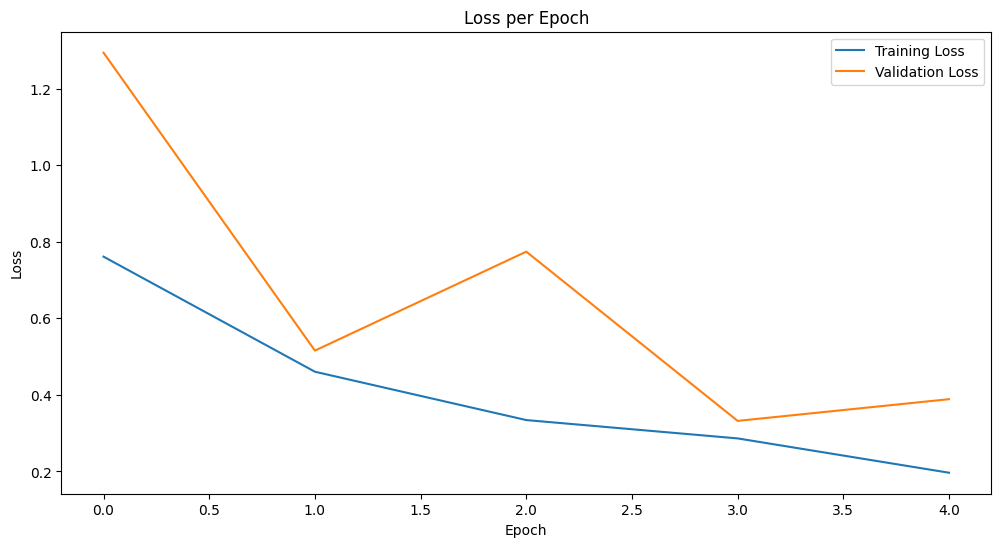

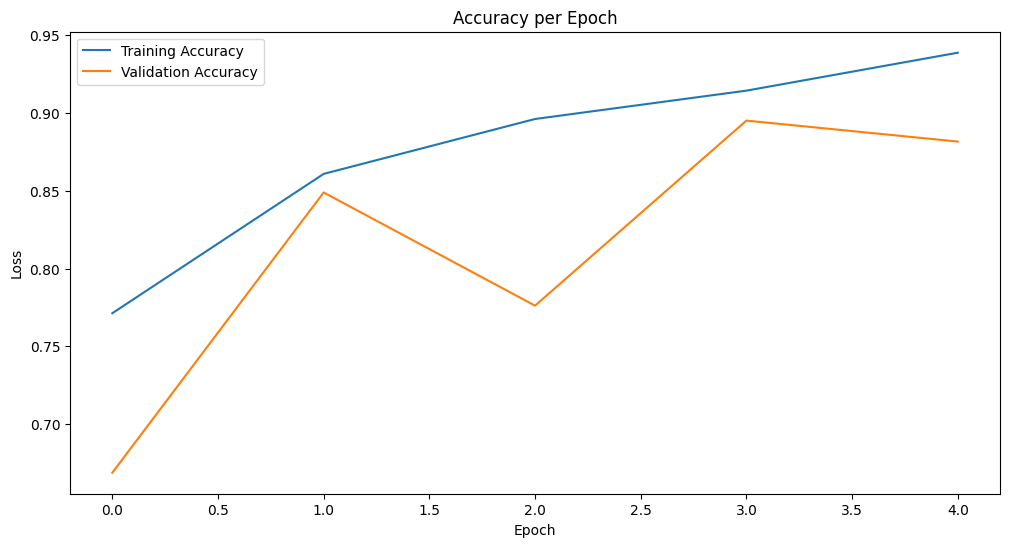

In [16]:
# TODO: 5. Plot the loss and accuracy curves.
plt.figure(figsize=(12,6))
plt.plot(train_losses_resnet34, label="Training Loss")
plt.plot(val_losses_resnet34, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_accs_resnet34, label="Training Accuracy")
plt.plot(val_accs_resnet34, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [11]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [12]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 50
INIT_LR = 0.001
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 4.0
LOSS_RATIO = 0.7

In [13]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.

resnet18 = torchvision.models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

In [ ]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = torchvision.models.resnet34(weights=None)
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
resnet34.load_state_dict(torch.load("../models/resnet34_checkpoint.pkl", map_location=device))
resnet34 = resnet34.to(device)
resnet34.eval()


C:\ProgramData\Temp\ipykernel_17116\4149829658.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load("./resnet34_checkpoint.pkl", map_locat

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet18.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()


In [ ]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = [], [], [], []
torch.manual_seed(42)

# Track best validation accuracy
best_val_acc = 0.0 

for epoch in tqdm(range(MAX_EPOCH), desc="Epochs"):
    # Start training
    resnet18.train()

    # Reset labels and predictions and loss
    train_labels = []
    train_preds = []
    train_running_loss = 0

    # Shuffle training order once per epoch
    perm = torch.randperm(tensor_train.size(0))

    # Loop for each image in a batch
    for i in tqdm(range(0, tensor_train.size(0), BATCH_SIZE), desc="Train Batches", position=1, leave=False):
        idx = perm[i:i + BATCH_SIZE]
        imgs = tensor_train[idx].float().to(device)
        labels = labels_train_index[idx].to(device)

        # Reset the gradient from before
        optimizer.zero_grad()

        # Teacher forward pass
        with torch.no_grad():
            teacher_logits = resnet34(imgs)
        
        # Student forward pass
        student_logits = resnet18(imgs)

        # Softened targets from teacher (softmax with temperature)
        soft_targets = nn.functional.softmax(teacher_logits / TEMPERATURE, dim=1)
        
        # Student log probabilities softened by temperature
        soft_probs = nn.functional.log_softmax(student_logits / TEMPERATURE, dim=1)

        # Distillation loss (soft target loss), scaled by T^2
        soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_probs)) / soft_probs.size(0) * (TEMPERATURE ** 2)

        # Label loss
        label_loss = criterion(student_logits, labels)
        
        # Calculate weighted sum of loss
        loss = LOSS_RATIO * soft_targets_loss + (1 - LOSS_RATIO) * label_loss
        train_running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(student_logits, dim=1)
        train_labels.extend(labels.cpu().tolist())
        train_preds.extend(preds.cpu().tolist())

    # Find average loss
    train_loss = train_running_loss / ((tensor_train.size(0) + BATCH_SIZE - 1) // BATCH_SIZE)
    
    # Find accuracy by adding 1 if prediction matches label, and divide by all labels
    train_accuracy = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
    train_losses_resnet18.append(train_loss)
    train_accs_resnet18.append(train_accuracy)
    
    # Evaluate mode, no more training
    resnet18.eval()

    # Similar to train except no changes to gradient
    val_labels = []
    val_preds = []
    val_running_loss = 0
    num_val_batches = (tensor_val.size(0) + BATCH_SIZE - 1) // BATCH_SIZE
    
    with torch.no_grad():
        for i in tqdm(range(0, tensor_val.size(0), BATCH_SIZE), desc="Val Batches", position=1, leave=False):
            imgs = tensor_val[i:i + BATCH_SIZE].float().to(device)
            labels = labels_val_index[i:i + BATCH_SIZE].to(device)
            
            student_logits = resnet18(imgs)
            teacher_logits = resnet34(imgs)

            soft_targets = nn.functional.softmax(teacher_logits / TEMPERATURE, dim=1)
            soft_probs = nn.functional.log_softmax(student_logits / TEMPERATURE, dim=1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_probs)) / soft_probs.size(0) * (TEMPERATURE ** 2)
            label_loss = criterion(student_logits, labels)
            
            loss = LOSS_RATIO * soft_targets_loss + (1 - LOSS_RATIO) * label_loss
            val_running_loss += loss.item()
            
            preds = torch.argmax(student_logits, dim=1)
            val_labels.extend(labels.cpu().tolist())
            val_preds.extend(preds.cpu().tolist())
    
    # Find average validation loss
    val_loss = val_running_loss / num_val_batches

    #Find validation accuracy
    val_accuracy = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)
    val_losses_resnet18.append(val_loss)
    val_accs_resnet18.append(val_accuracy)
    
    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(resnet18.state_dict(), "../models/resnet18_checkpoint.pkl")
        tqdm.write(f"Saved model with Val Acc: {best_val_acc:.4f}")
    
    # Write stats
    tqdm.write(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_accuracy:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}")

Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.99it/s]
                                                                
Epochs:   2%|▏         | 1/50 [01:03<52:02, 63.73s/it]

Saved model with Val Acc: 0.5704
Epoch 1: Train Loss=4.9590, Train Acc=0.4776, Val Loss=4.3312, Val Acc=0.5704



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.98it/s]
                                                                
Epochs:   4%|▍         | 2/50 [02:07<50:46, 63.47s/it]

Saved model with Val Acc: 0.6088
Epoch 2: Train Loss=3.4562, Train Acc=0.6212, Val Loss=3.5474, Val Acc=0.6088



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  5.00it/s]
                                                                
Epochs:   6%|▌         | 3/50 [03:10<49:44, 63.49s/it]

Saved model with Val Acc: 0.6462
Epoch 3: Train Loss=2.6540, Train Acc=0.6968, Val Loss=3.1887, Val Acc=0.6462



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.98it/s]
                                                                
Epochs:   8%|▊         | 4/50 [04:14<48:41, 63.51s/it]

Saved model with Val Acc: 0.7127
Epoch 4: Train Loss=2.2419, Train Acc=0.7335, Val Loss=2.3054, Val Acc=0.7127



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  10%|█         | 5/50 [05:17<47:36, 63.47s/it]

Saved model with Val Acc: 0.7558
Epoch 5: Train Loss=1.8523, Train Acc=0.7756, Val Loss=1.9376, Val Acc=0.7558



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.95it/s]
                                                                
Epochs:  12%|█▏        | 6/50 [06:20<46:31, 63.44s/it]

Saved model with Val Acc: 0.7931
Epoch 6: Train Loss=1.5881, Train Acc=0.7988, Val Loss=1.5291, Val Acc=0.7931



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.97it/s]
                                                                
Epochs:  14%|█▍        | 7/50 [07:24<45:29, 63.49s/it]

Saved model with Val Acc: 0.7969
Epoch 7: Train Loss=1.4503, Train Acc=0.8151, Val Loss=1.4244, Val Acc=0.7969



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  5.00it/s]
                                                                
Epochs:  16%|█▌        | 8/50 [08:28<44:28, 63.54s/it]

Saved model with Val Acc: 0.8077
Epoch 8: Train Loss=1.2272, Train Acc=0.8314, Val Loss=1.4646, Val Acc=0.8077



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.99it/s]
                                                                
Epochs:  18%|█▊        | 9/50 [09:31<43:25, 63.56s/it]

Saved model with Val Acc: 0.8200
Epoch 9: Train Loss=1.1133, Train Acc=0.8467, Val Loss=1.3471, Val Acc=0.8200



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  20%|██        | 10/50 [10:35<42:20, 63.51s/it]

Saved model with Val Acc: 0.8396
Epoch 10: Train Loss=0.9868, Train Acc=0.8632, Val Loss=0.9602, Val Acc=0.8396



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.99it/s]
                                                                
Epochs:  22%|██▏       | 11/50 [11:38<41:15, 63.47s/it]

Epoch 11: Train Loss=0.8517, Train Acc=0.8774, Val Loss=1.1324, Val Acc=0.8338



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.96it/s]
                                                                
Epochs:  24%|██▍       | 12/50 [12:41<40:12, 63.48s/it]

Saved model with Val Acc: 0.8519
Epoch 12: Train Loss=0.7711, Train Acc=0.8872, Val Loss=0.9000, Val Acc=0.8519



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  26%|██▌       | 13/50 [13:45<39:08, 63.47s/it]

Saved model with Val Acc: 0.8577
Epoch 13: Train Loss=0.6852, Train Acc=0.8985, Val Loss=0.9184, Val Acc=0.8577



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  28%|██▊       | 14/50 [14:48<38:04, 63.47s/it]

Saved model with Val Acc: 0.8708
Epoch 14: Train Loss=0.6106, Train Acc=0.9109, Val Loss=0.7089, Val Acc=0.8708



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.97it/s]
                                                                
Epochs:  30%|███       | 15/50 [15:52<37:00, 63.44s/it]

Epoch 15: Train Loss=0.5647, Train Acc=0.9156, Val Loss=0.7474, Val Acc=0.8662



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.99it/s]
                                                                
Epochs:  32%|███▏      | 16/50 [16:55<35:56, 63.43s/it]

Epoch 16: Train Loss=0.4927, Train Acc=0.9303, Val Loss=0.8482, Val Acc=0.8600



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.98it/s]
                                                                
Epochs:  34%|███▍      | 17/50 [17:58<34:52, 63.40s/it]

Epoch 17: Train Loss=0.4629, Train Acc=0.9313, Val Loss=0.7325, Val Acc=0.8677



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  36%|███▌      | 18/50 [19:02<33:48, 63.39s/it]

Epoch 18: Train Loss=0.4403, Train Acc=0.9358, Val Loss=0.8647, Val Acc=0.8604



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.96it/s]
                                                                
Epochs:  38%|███▊      | 19/50 [20:05<32:44, 63.37s/it]

Epoch 19: Train Loss=0.4455, Train Acc=0.9367, Val Loss=0.7236, Val Acc=0.8635



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  40%|████      | 20/50 [21:09<31:40, 63.36s/it]

Epoch 20: Train Loss=0.3737, Train Acc=0.9494, Val Loss=0.7278, Val Acc=0.8669



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.98it/s]
                                                                
Epochs:  42%|████▏     | 21/50 [22:12<30:37, 63.38s/it]

Saved model with Val Acc: 0.8754
Epoch 21: Train Loss=0.3454, Train Acc=0.9500, Val Loss=0.6264, Val Acc=0.8754



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.93it/s]
                                                                
Epochs:  44%|████▍     | 22/50 [23:15<29:33, 63.36s/it]

Epoch 22: Train Loss=0.3481, Train Acc=0.9522, Val Loss=0.6007, Val Acc=0.8723



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.96it/s]
                                                                
Epochs:  46%|████▌     | 23/50 [24:19<28:31, 63.38s/it]

Saved model with Val Acc: 0.8812
Epoch 23: Train Loss=0.3413, Train Acc=0.9499, Val Loss=0.6685, Val Acc=0.8812



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.96it/s]
                                                                
Epochs:  48%|████▊     | 24/50 [25:22<27:27, 63.36s/it]

Epoch 24: Train Loss=0.3341, Train Acc=0.9544, Val Loss=0.6766, Val Acc=0.8704



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.96it/s]
                                                                
Epochs:  50%|█████     | 25/50 [26:25<26:24, 63.40s/it]

Epoch 25: Train Loss=0.3141, Train Acc=0.9583, Val Loss=0.7387, Val Acc=0.8542



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.93it/s]
                                                                
Epochs:  52%|█████▏    | 26/50 [27:29<25:23, 63.48s/it]

Epoch 26: Train Loss=0.3056, Train Acc=0.9554, Val Loss=0.6681, Val Acc=0.8723



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.95it/s]
                                                                
Epochs:  54%|█████▍    | 27/50 [28:33<24:20, 63.51s/it]

Epoch 27: Train Loss=0.2914, Train Acc=0.9574, Val Loss=0.6608, Val Acc=0.8662



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.94it/s]
                                                                
Epochs:  56%|█████▌    | 28/50 [29:36<23:16, 63.49s/it]

Epoch 28: Train Loss=0.2692, Train Acc=0.9613, Val Loss=0.6886, Val Acc=0.8731



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  5.00it/s]
                                                                
Epochs:  58%|█████▊    | 29/50 [30:40<22:12, 63.47s/it]

Epoch 29: Train Loss=0.2887, Train Acc=0.9612, Val Loss=0.6503, Val Acc=0.8750



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  5.00it/s]
                                                                
Epochs:  60%|██████    | 30/50 [31:43<21:08, 63.44s/it]

Epoch 30: Train Loss=0.2573, Train Acc=0.9644, Val Loss=0.6154, Val Acc=0.8792



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  62%|██████▏   | 31/50 [32:46<20:04, 63.42s/it]

Epoch 31: Train Loss=0.2463, Train Acc=0.9655, Val Loss=0.5654, Val Acc=0.8804



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.98it/s]
                                                                
Epochs:  64%|██████▍   | 32/50 [33:50<19:02, 63.46s/it]

Saved model with Val Acc: 0.8858
Epoch 32: Train Loss=0.2470, Train Acc=0.9645, Val Loss=0.5472, Val Acc=0.8858



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.98it/s]
                                                                
Epochs:  66%|██████▌   | 33/50 [34:53<17:59, 63.49s/it]

Saved model with Val Acc: 0.8862
Epoch 33: Train Loss=0.2313, Train Acc=0.9672, Val Loss=0.5826, Val Acc=0.8862



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.96it/s]
                                                                
Epochs:  68%|██████▊   | 34/50 [35:57<16:55, 63.46s/it]

Epoch 34: Train Loss=0.2276, Train Acc=0.9686, Val Loss=0.6178, Val Acc=0.8819



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.98it/s]
                                                                
Epochs:  70%|███████   | 35/50 [37:00<15:51, 63.45s/it]

Epoch 35: Train Loss=0.2174, Train Acc=0.9683, Val Loss=0.5995, Val Acc=0.8715



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.97it/s]
                                                                
Epochs:  72%|███████▏  | 36/50 [38:04<14:48, 63.44s/it]

Epoch 36: Train Loss=0.2064, Train Acc=0.9706, Val Loss=0.5752, Val Acc=0.8765



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.98it/s]
                                                                
Epochs:  74%|███████▍  | 37/50 [39:07<13:44, 63.45s/it]

Epoch 37: Train Loss=0.1969, Train Acc=0.9721, Val Loss=0.5877, Val Acc=0.8792



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  5.02it/s]
                                                                
Epochs:  76%|███████▌  | 38/50 [40:11<12:41, 63.44s/it]

Epoch 38: Train Loss=0.2050, Train Acc=0.9686, Val Loss=0.5364, Val Acc=0.8815



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  78%|███████▊  | 39/50 [41:14<11:37, 63.41s/it]

Epoch 39: Train Loss=0.1822, Train Acc=0.9723, Val Loss=0.5640, Val Acc=0.8812



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  5.00it/s]
                                                                
Epochs:  80%|████████  | 40/50 [42:17<10:33, 63.39s/it]

Epoch 40: Train Loss=0.1859, Train Acc=0.9709, Val Loss=0.5680, Val Acc=0.8815



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.97it/s]
                                                                
Epochs:  82%|████████▏ | 41/50 [43:21<09:30, 63.40s/it]

Epoch 41: Train Loss=0.1751, Train Acc=0.9754, Val Loss=0.5393, Val Acc=0.8846



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.95it/s]
                                                                
Epochs:  84%|████████▍ | 42/50 [44:24<08:27, 63.40s/it]

Epoch 42: Train Loss=0.1684, Train Acc=0.9732, Val Loss=0.5361, Val Acc=0.8850



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  4.96it/s]
                                                                
Epochs:  86%|████████▌ | 43/50 [45:28<07:23, 63.40s/it]

Epoch 43: Train Loss=0.1730, Train Acc=0.9724, Val Loss=0.5880, Val Acc=0.8719



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  88%|████████▊ | 44/50 [46:31<06:20, 63.39s/it]

Epoch 44: Train Loss=0.1801, Train Acc=0.9722, Val Loss=0.5483, Val Acc=0.8769



Train Batches: 100%|██████████| 244/244 [00:53<00:00,  5.01it/s]
                                                                
Epochs:  90%|█████████ | 45/50 [47:34<05:17, 63.40s/it]

Epoch 45: Train Loss=0.1653, Train Acc=0.9765, Val Loss=0.5197, Val Acc=0.8846



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.98it/s]
                                                                
Epochs:  92%|█████████▏| 46/50 [48:38<04:13, 63.38s/it]

Epoch 46: Train Loss=0.1544, Train Acc=0.9754, Val Loss=0.5136, Val Acc=0.8862



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  5.00it/s]
                                                                
Epochs:  94%|█████████▍| 47/50 [49:41<03:10, 63.37s/it]

Saved model with Val Acc: 0.8881
Epoch 47: Train Loss=0.1563, Train Acc=0.9764, Val Loss=0.5170, Val Acc=0.8881



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.97it/s]
                                                                
Epochs:  96%|█████████▌| 48/50 [50:44<02:06, 63.37s/it]

Epoch 48: Train Loss=0.1543, Train Acc=0.9744, Val Loss=0.5254, Val Acc=0.8804



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.99it/s]
                                                                
Epochs:  98%|█████████▊| 49/50 [51:48<01:03, 63.36s/it]

Epoch 49: Train Loss=0.1482, Train Acc=0.9776, Val Loss=0.5875, Val Acc=0.8758



Train Batches: 100%|██████████| 244/244 [00:52<00:00,  4.99it/s]
                                                                
Epochs: 100%|██████████| 50/50 [52:51<00:00, 63.43s/it]

Saved model with Val Acc: 0.8900
Epoch 50: Train Loss=0.1532, Train Acc=0.9753, Val Loss=0.5002, Val Acc=0.8900


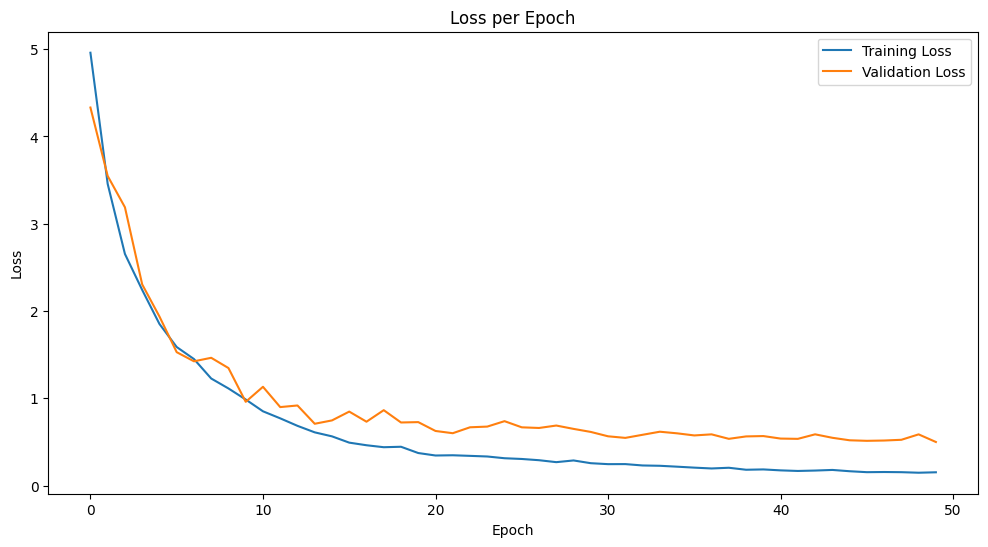

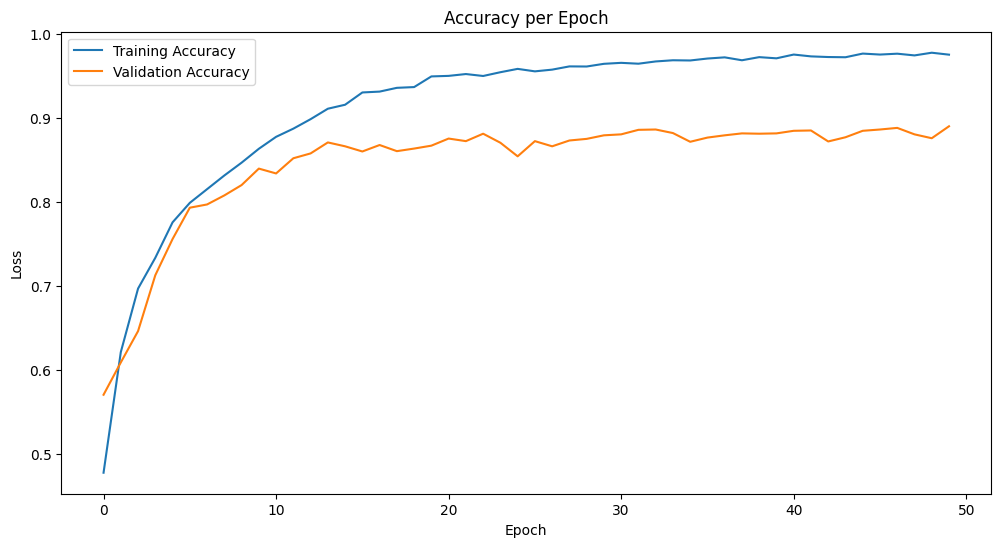

In [23]:
# TODO: 6. Plot the loss and accuracy curves.

plt.figure(figsize=(12,6))
plt.plot(train_losses_resnet18, label="Training Loss")
plt.plot(val_losses_resnet18, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_accs_resnet18, label="Training Accuracy")
plt.plot(val_accs_resnet18, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [ ]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = torchvision.models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18.load_state_dict(torch.load("../models/resnet18_checkpoint.pkl", map_location=device))
resnet18 = resnet18.to(device)
resnet18.eval()


C:\ProgramData\Temp\ipykernel_17116\1544327625.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load("./resnet18_checkpoint.pkl", map_locat

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []

with torch.no_grad():
    for i in tqdm(range(0, tensor_test.size(0), BATCH_SIZE), desc="Test Batches"):
        batch = tensor_test[i:i + BATCH_SIZE].float().to(device)
        outputs = resnet18(batch)
        pred_labels = torch.argmax(outputs, dim=1)
        predictions.extend(pred_labels.cpu().tolist())

Test Batches: 100%|██████████| 82/82 [00:14<00:00,  5.68it/s]


In [18]:
print(label_to_index)

{'african_elephant': 0, 'airliner': 1, 'banana': 2, 'convertible_car': 3, 'golden_retriever': 4, 'goldfish': 5, 'parachute': 6, 'rugby': 7, 'sunglasses': 8, 'tiger_cat': 9}


In [ ]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

index_to_label = {index: label for label, index in label_to_index.items()}


# Write to csv
with open("../submission.csv", mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["file_name", "label"])
    for idx, pred in enumerate(predictions):
        writer.writerow([f"{idx}.jpg",index_to_label[pred]])
